In [1]:
import os, sys
sys.path.insert(0, os.path.abspath(os.path.join("..", "..")))

# Making predictions

Use the code in this project, combined with `open_cp`.  Eventually we'll use the `scripted` package to write short Python scripts.  So this notebook is just a testbed.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import lzma, datetime, time
import descartes

import open_cp.sources.chicago
import open_cp.data
import open_cp.geometry

import opencrimedata.chicago

import sepp.sepp_grid
import sepp.grid_nonparam
import sepp.sepp_grid_space
import sepp.sepp_full
import sepp.sepp_fixed

In [3]:
datadir = os.path.join("..", "..", "..", "..", "..", "Data")
#datadir = os.path.join("/media", "disk", "Data")
open_cp.sources.chicago.set_data_directory(datadir)

proj = opencrimedata.chicago.projector()

In [4]:
def gen():
    with lzma.open(os.path.join(datadir, "chicago_all.csv.xz"), "rt") as file:
        for row in opencrimedata.chicago.load_only_with_point(file):
            if row.crime_type == "BURGLARY":
                yield row 

#all_points = [(row.datetime, proj(*row.point)) for row in gen()]
#all_points = open_cp.data.TimedPoints.from_coords([p[0] for p in all_points],
#        [p[1][0] for p in all_points], [p[1][1] for p in all_points])

In [5]:
import pickle, lzma
#with lzma.open("temp.pic.xz", "w") as f:
#    pickle.dump(all_points, f)
    
with lzma.open("temp.pic.xz") as f:
    all_points = pickle.load(f)

In [6]:
def load(side, start, end):
    geo = open_cp.sources.chicago.get_side(side)
    grid = open_cp.data.Grid(150, 150, 0, 0)
    grid = open_cp.geometry.mask_grid_by_intersection(geo, grid)
    mask = (all_points.timestamps >= start) & (all_points.timestamps < end)
    points = all_points[mask]
    points = open_cp.geometry.intersect_timed_points(points, geo)
    return grid, points, geo

def load_score_data(geo, start, end):
    mask = (all_points.timestamps >= start) & (all_points.timestamps < end)
    points = all_points[mask]
    return open_cp.geometry.intersect_timed_points(points, geo)

grid, points, geo = load("North", np.datetime64("2016-01-01"), np.datetime64("2016-10-01"))
score_points = load_score_data(geo, np.datetime64("2016-01-01"), np.datetime64("2017-01-01"))

## Train with `ExpDecayTrainer`

In [7]:
trainer = sepp.sepp_grid.ExpDecayTrainer(grid, allow_repeats=True)
trainer.data = points
model = trainer.train(np.datetime64("2016-10-01"), iterations=50)
model

ExpDecayModel(T=273.9583333333333, theta=0.017156037940950466, omega=8.506437554838014, mu size=(39, 65)

In [8]:
predictor = sepp.sepp_grid.ExpDecayTrainer(grid, allow_repeats=True)
predictor.data = score_points
cells, T = predictor.make_points(np.datetime64("2016-10-01"))
pred = predictor.prediction(model, np.asarray(cells))

In [9]:
pred

GridPredictionArray(offset=(349500,582300), size=150x150, risk intensity size=65x39)

In [10]:
back = predictor.prediction_from_background(model)

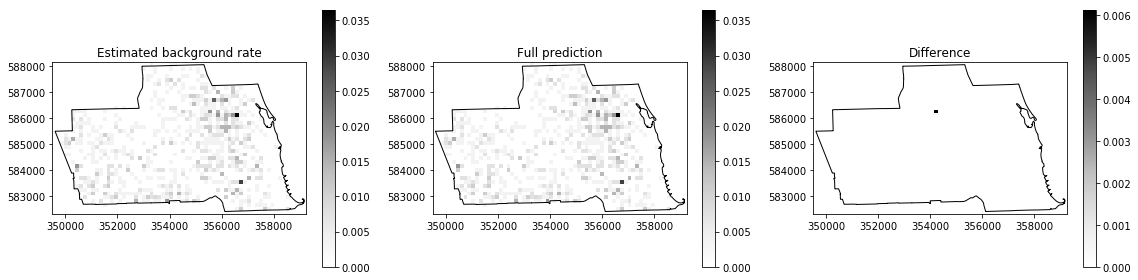

In [11]:
fig, axes = plt.subplots(ncols=3, figsize=(16,4))

for ax in axes:
    ax.add_patch(descartes.PolygonPatch(geo, fc="none"))
    ax.set_aspect(1)
    
mappable = axes[0].pcolor(*back.mesh_data(), back.intensity_matrix, cmap="Greys", rasterized=True)
fig.colorbar(mappable, ax=axes[0])
axes[0].set_title("Estimated background rate")

mappable = axes[1].pcolor(*pred.mesh_data(), pred.intensity_matrix, cmap="Greys", rasterized=True)
fig.colorbar(mappable, ax=axes[1])
axes[1].set_title("Full prediction")

mat = pred.intensity_matrix - back.intensity_matrix
mappable = axes[2].pcolor(*pred.mesh_data(), mat, cmap="Greys", rasterized=True)
fig.colorbar(mappable, ax=axes[2])
axes[2].set_title("Difference")

fig.tight_layout()

## Train with `NonParamTrainer`

In [12]:
trainer = sepp.grid_nonparam.NonParamTrainer(grid, bandwidth=1)
trainer.data = points
model = trainer.train(np.datetime64("2016-10-01"), iterations=50, use_fast=True)
model

ExpDecayModel(T=273.9583333333333, theta=0.02647746320326562, bandwidth=1, alpha=[  9.99937068e-01   3.40579747e-05   1.85663928e-09   2.88701459e-05   3.75319313e-25   1.84687465e-09   4.66717223e-38   2.69594346e-35   3.11412501e-22   8.82297266e-32 ... ]

In [13]:
predictor = sepp.grid_nonparam.NonParamTrainer(grid, bandwidth=1)
predictor.data = score_points
cells, T = predictor.make_points(np.datetime64("2016-10-01"))
pred = predictor.prediction(model, np.asarray(cells))

back = predictor.prediction_from_background(model)

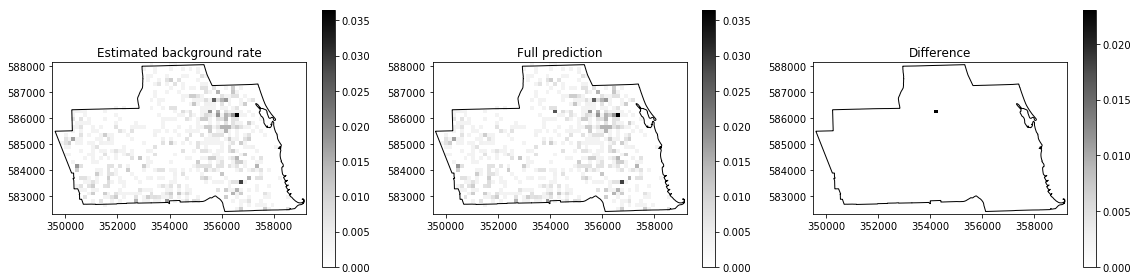

In [14]:
fig, axes = plt.subplots(ncols=3, figsize=(16,4))

for ax in axes:
    ax.add_patch(descartes.PolygonPatch(geo, fc="none"))
    ax.set_aspect(1)
    
mappable = axes[0].pcolor(*back.mesh_data(), back.intensity_matrix, cmap="Greys", rasterized=True)
fig.colorbar(mappable, ax=axes[0])
axes[0].set_title("Estimated background rate")

mappable = axes[1].pcolor(*pred.mesh_data(), pred.intensity_matrix, cmap="Greys", rasterized=True)
fig.colorbar(mappable, ax=axes[1])
axes[1].set_title("Full prediction")

mat = pred.intensity_matrix - back.intensity_matrix
mappable = axes[2].pcolor(*pred.mesh_data(), mat, cmap="Greys", rasterized=True)
fig.colorbar(mappable, ax=axes[2])
axes[2].set_title("Difference")

fig.tight_layout()

## Train with `sepp_grid_space.Trainer1`

Exponential decay in time, "capped" gaussian in space

This predictor also supports the "fast" interface, which is indeed a lot faster.  But we find that using the histogram approximation as well leads to significant differences in the prediction.

In [15]:
trainer = sepp.sepp_grid_space.Trainer1(grid, 5)
trainer.data = points
model = trainer.train(datetime.datetime(2017,1,1), iterations=50)
model

Model1(mu size=(39, 65), T=365.9583333333333, grid=RectangularRegion( (349500,582300) -> (359250,588150) ), theta=0.14397454172123939, omega=0.01446852874262879, alpha=0.008971359603397266, sigma^2=31.018383032807805, r0=5

In [16]:
predictor = trainer.to_predictor(model)

In [17]:
start = time.clock()
predictor.data = score_points
pred = predictor.predict(datetime.datetime(2016, 10, 1), end_time=datetime.datetime(2016, 10, 2),
                        time_samples=5, space_samples=-5)
time.clock() - start

50.919999999999995

In [18]:
back = predictor.background_predict(datetime.datetime(2016, 10, 1), space_samples=-5)

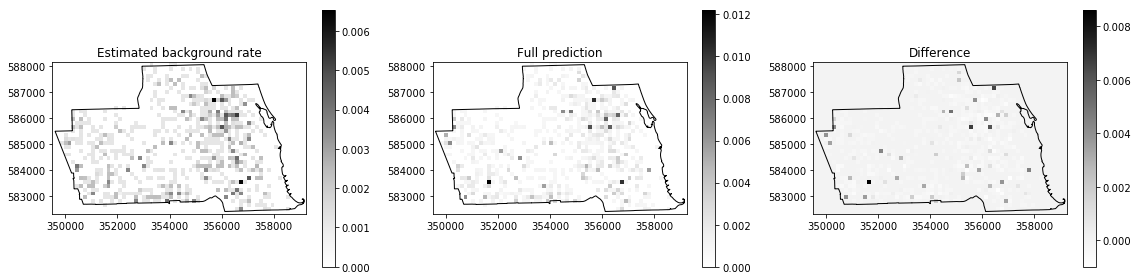

In [19]:
fig, axes = plt.subplots(ncols=3, figsize=(16,4))

for ax in axes:
    ax.add_patch(descartes.PolygonPatch(geo, fc="none"))
    ax.set_aspect(1)
    
mappable = axes[0].pcolor(*back.mesh_data(), back.intensity_matrix, cmap="Greys", rasterized=True)
fig.colorbar(mappable, ax=axes[0])
axes[0].set_title("Estimated background rate")

mappable = axes[1].pcolor(*pred.mesh_data(), pred.intensity_matrix, cmap="Greys", rasterized=True)
fig.colorbar(mappable, ax=axes[1])
axes[1].set_title("Full prediction")

mat = pred.intensity_matrix - back.intensity_matrix
mappable = axes[2].pcolor(*pred.mesh_data(), mat, cmap="Greys", rasterized=True)
fig.colorbar(mappable, ax=axes[2])
axes[2].set_title("Difference")

fig.tight_layout()

Use the faster predictor, which is a lot faster, and gives almost exactly (up to numerical error) the same prediction.

In [20]:
fp = predictor.to_fast_split_predictor()
start = time.clock()
fp.data = score_points
fpred = fp.predict(datetime.datetime(2016, 10, 1), end_time=datetime.datetime(2016, 10, 2),
                        time_samples=5, space_samples=-5)
time.clock() - start

3.200000000000003

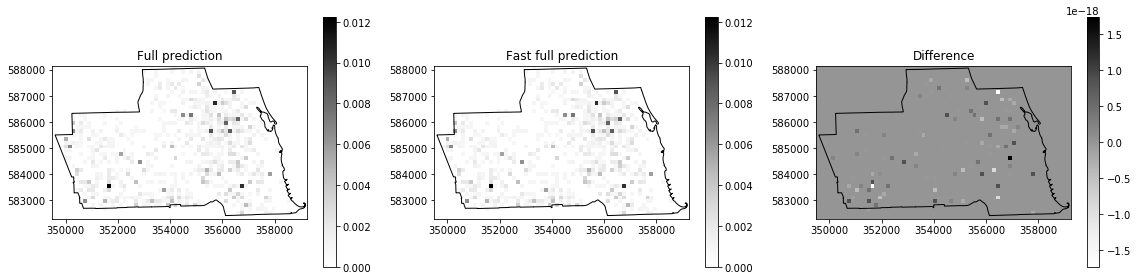

In [21]:
fig, axes = plt.subplots(ncols=3, figsize=(16,4))

for ax in axes:
    ax.add_patch(descartes.PolygonPatch(geo, fc="none"))
    ax.set_aspect(1)
    
mappable = axes[0].pcolor(*pred.mesh_data(), pred.intensity_matrix, cmap="Greys", rasterized=True)
fig.colorbar(mappable, ax=axes[0])
axes[0].set_title("Full prediction")

mappable = axes[1].pcolor(*fpred.mesh_data(), fpred.intensity_matrix, cmap="Greys", rasterized=True)
fig.colorbar(mappable, ax=axes[1])
axes[1].set_title("Fast full prediction")

mat = pred.intensity_matrix - fpred.intensity_matrix
mappable = axes[2].pcolor(*pred.mesh_data(), mat, cmap="Greys", rasterized=True)
fig.colorbar(mappable, ax=axes[2])
axes[2].set_title("Difference")

fig.tight_layout()

Now use the histogram estimator.  For this simple model, this is a tiny bit slower, and quite inaccurate when it comes to making predictions.

In [22]:
fph = predictor.to_fast_split_predictor_histogram(time_bin_size=1, space_bin_size=0.2)

In [23]:
start = time.clock()
fph.data = score_points
fpred = fph.predict(datetime.datetime(2016, 10, 1), end_time=datetime.datetime(2016, 10, 2),
                        time_samples=5, space_samples=-5)
time.clock() - start

3.3999999999999915

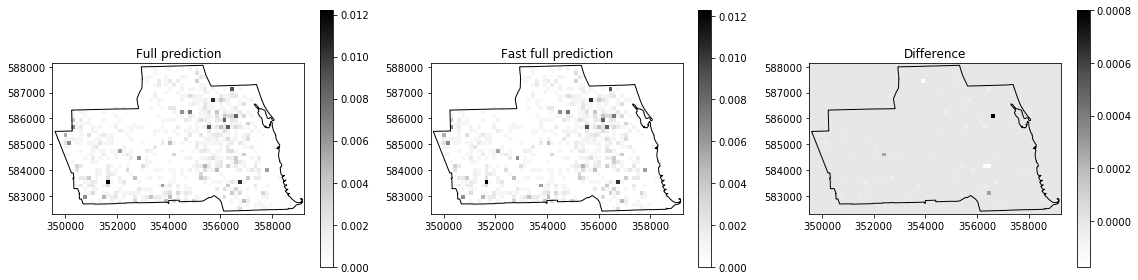

In [24]:
fig, axes = plt.subplots(ncols=3, figsize=(16,4))

for ax in axes:
    ax.add_patch(descartes.PolygonPatch(geo, fc="none"))
    ax.set_aspect(1)
    
mappable = axes[0].pcolor(*pred.mesh_data(), pred.intensity_matrix, cmap="Greys", rasterized=True)
fig.colorbar(mappable, ax=axes[0])
axes[0].set_title("Full prediction")

mappable = axes[1].pcolor(*fpred.mesh_data(), fpred.intensity_matrix, cmap="Greys", rasterized=True)
fig.colorbar(mappable, ax=axes[1])
axes[1].set_title("Fast full prediction")

mat = pred.intensity_matrix - fpred.intensity_matrix
mappable = axes[2].pcolor(*pred.mesh_data(), mat, cmap="Greys", rasterized=True)
fig.colorbar(mappable, ax=axes[2])
axes[2].set_title("Difference")

fig.tight_layout()

In [25]:
np.max(np.abs((fp.background_predict().intensity_matrix - fph.background_predict().intensity_matrix).data))

1.3877787807814457e-17

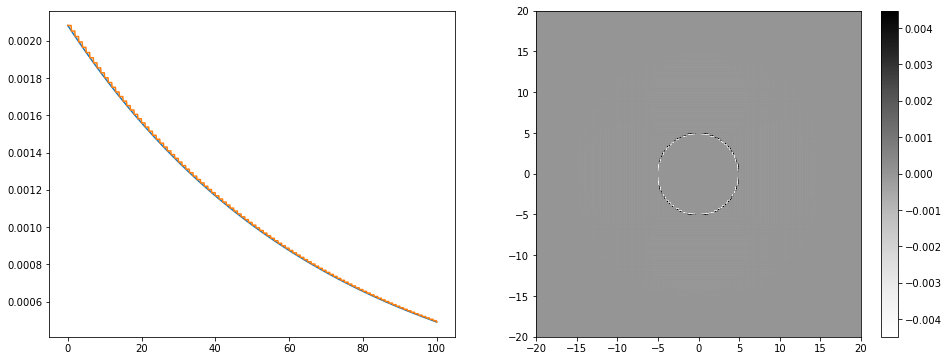

In [26]:
fig, axes = plt.subplots(ncols=2, figsize=(16,6))

ax = axes[0]
t = np.linspace(0, 100, 1000)
ax.plot(t, fp.fast_predictor_base.time_kernel(t))
ax.plot(t, fph.fast_predictor_base.time_kernel(t))

def ker(pts):
    return fph.fast_predictor_base.space_kernel(pts) - fp.fast_predictor_base.space_kernel(pts)
cts = open_cp.predictors.KernelRiskPredictor(ker, samples=-5)
g = sepp.sepp_grid.ConcreteBoundedGrid(.1, .1, -20, -20, 400, 400)
g = open_cp.predictors.GridPredictionArray.from_continuous_prediction_grid(cts, g)
mappable = axes[1].pcolor(*g.mesh_data(), g.intensity_matrix, cmap="Greys", rasterized=True)
fig.colorbar(mappable, ax=axes[1])

## Train with `sepp_grid_space.Trainer2`

Exponential decay in time, circular window in space

In [27]:
trainer = sepp.sepp_grid_space.Trainer2(grid, 20)
trainer.data = points
model = trainer.train(datetime.datetime(2017,1,1), iterations=50)
model

Model2(mu size=(39, 65), T=365.9583333333333, grid=RectangularRegion( (349500,582300) -> (359250,588150) ), theta=0.12879439738337245, omega=0.02051653909878596, r0=20

In [28]:
predictor = trainer.to_predictor(model)
predictor.data = score_points
start = time.clock()
pred = predictor.predict(datetime.datetime(2016, 10, 1), end_time=datetime.datetime(2016, 10, 2),
                        time_samples=5, space_samples=-5)
print(time.clock() - start)
back = predictor.background_predict(datetime.datetime(2016, 10, 1), space_samples=-5)

37.22


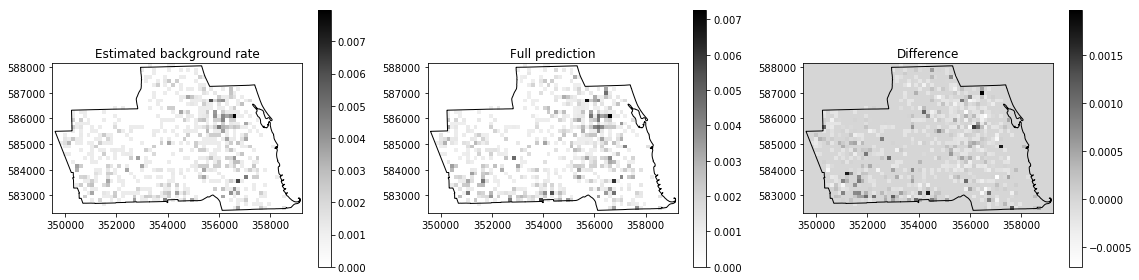

In [29]:
fig, axes = plt.subplots(ncols=3, figsize=(16,4))

for ax in axes:
    ax.add_patch(descartes.PolygonPatch(geo, fc="none"))
    ax.set_aspect(1)
    
mappable = axes[0].pcolor(*back.mesh_data(), back.intensity_matrix, cmap="Greys", rasterized=True)
fig.colorbar(mappable, ax=axes[0])
axes[0].set_title("Estimated background rate")

mappable = axes[1].pcolor(*pred.mesh_data(), pred.intensity_matrix, cmap="Greys", rasterized=True)
fig.colorbar(mappable, ax=axes[1])
axes[1].set_title("Full prediction")

mat = pred.intensity_matrix - back.intensity_matrix
mappable = axes[2].pcolor(*pred.mesh_data(), mat, cmap="Greys", rasterized=True)
fig.colorbar(mappable, ax=axes[2])
axes[2].set_title("Difference")

fig.tight_layout()

In [30]:
fp = predictor.to_fast_split_predictor()
start = time.clock()
fp.data = score_points
fpred = fp.predict(datetime.datetime(2016, 10, 1), end_time=datetime.datetime(2016, 10, 2),
                        time_samples=5, space_samples=-5)
time.clock() - start

1.5100000000000193

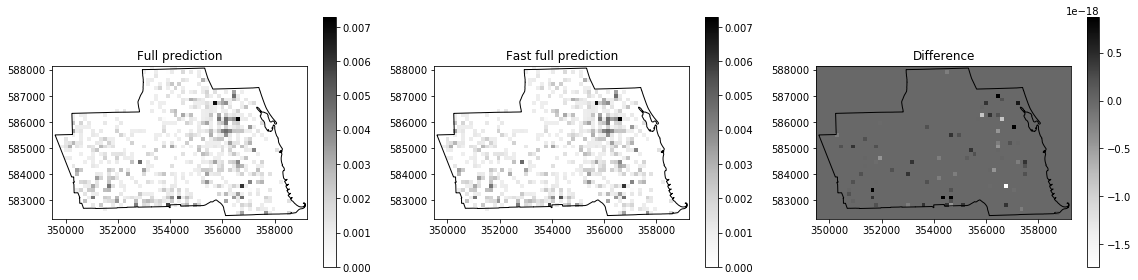

In [31]:
fig, axes = plt.subplots(ncols=3, figsize=(16,4))

for ax in axes:
    ax.add_patch(descartes.PolygonPatch(geo, fc="none"))
    ax.set_aspect(1)
    
mappable = axes[0].pcolor(*pred.mesh_data(), pred.intensity_matrix, cmap="Greys", rasterized=True)
fig.colorbar(mappable, ax=axes[0])
axes[0].set_title("Full prediction")

mappable = axes[1].pcolor(*fpred.mesh_data(), fpred.intensity_matrix, cmap="Greys", rasterized=True)
fig.colorbar(mappable, ax=axes[1])
axes[1].set_title("Fast full prediction")

mat = pred.intensity_matrix - fpred.intensity_matrix
mappable = axes[2].pcolor(*pred.mesh_data(), mat, cmap="Greys", rasterized=True)
fig.colorbar(mappable, ax=axes[2])
axes[2].set_title("Difference")

fig.tight_layout()

## Train with `sepp_grid_space.Trainer3`

Histogram in time, circular window in space

In [32]:
trainer = sepp.sepp_grid_space.Trainer3(grid, r0=20, bandwidth=1)
trainer.data = points
model = trainer.train(datetime.datetime(2017,1,1), iterations=50)
model

Model3(mu size=(39, 65), T=365.9583333333333, grid=RectangularRegion( (349500,582300) -> (359250,588150) ), theta=0.06381424508571826, bandwidth=1, r0=20

In [33]:
predictor = trainer.to_predictor(model)
predictor.data = score_points
start = time.clock()
pred = predictor.predict(datetime.datetime(2016, 10, 1), end_time=datetime.datetime(2016, 10, 2),
                        time_samples=5, space_samples=-5)
print(time.clock() - start)
back = predictor.background_predict(datetime.datetime(2016, 10, 1), space_samples=-5)

44.70000000000002


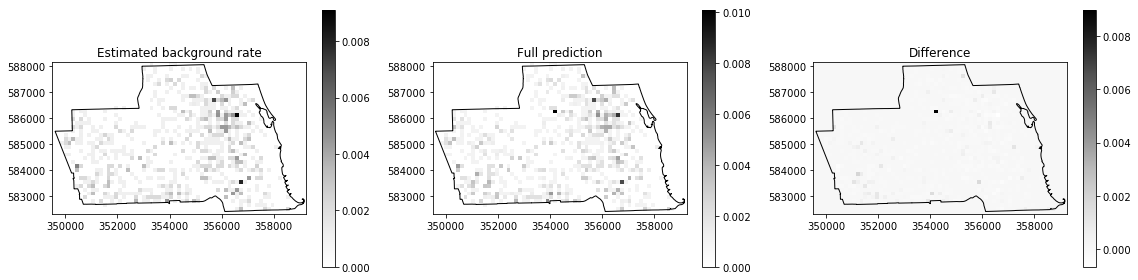

In [34]:
fig, axes = plt.subplots(ncols=3, figsize=(16,4))

for ax in axes:
    ax.add_patch(descartes.PolygonPatch(geo, fc="none"))
    ax.set_aspect(1)
    
mappable = axes[0].pcolor(*back.mesh_data(), back.intensity_matrix, cmap="Greys", rasterized=True)
fig.colorbar(mappable, ax=axes[0])
axes[0].set_title("Estimated background rate")

mappable = axes[1].pcolor(*pred.mesh_data(), pred.intensity_matrix, cmap="Greys", rasterized=True)
fig.colorbar(mappable, ax=axes[1])
axes[1].set_title("Full prediction")

mat = pred.intensity_matrix - back.intensity_matrix
mappable = axes[2].pcolor(*pred.mesh_data(), mat, cmap="Greys", rasterized=True)
fig.colorbar(mappable, ax=axes[2])
axes[2].set_title("Difference")

fig.tight_layout()

In [35]:
fp = predictor.to_fast_split_predictor()
start = time.clock()
fp.data = score_points
fpred = fp.predict(datetime.datetime(2016, 10, 1), end_time=datetime.datetime(2016, 10, 2),
                        time_samples=5, space_samples=-5)
time.clock() - start

1.6599999999999682

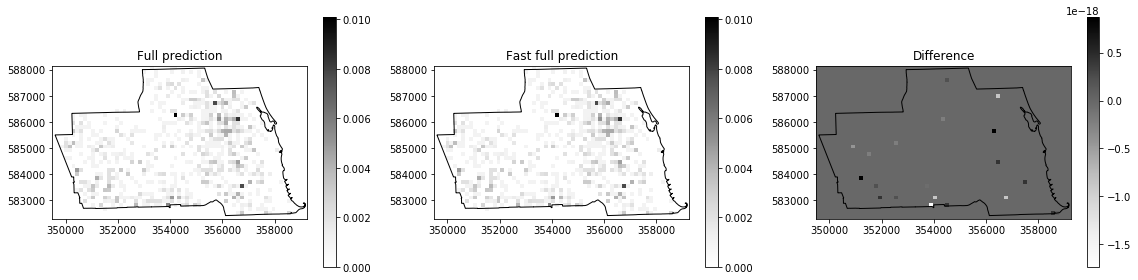

In [36]:
fig, axes = plt.subplots(ncols=3, figsize=(16,4))

for ax in axes:
    ax.add_patch(descartes.PolygonPatch(geo, fc="none"))
    ax.set_aspect(1)
    
mappable = axes[0].pcolor(*pred.mesh_data(), pred.intensity_matrix, cmap="Greys", rasterized=True)
fig.colorbar(mappable, ax=axes[0])
axes[0].set_title("Full prediction")

mappable = axes[1].pcolor(*fpred.mesh_data(), fpred.intensity_matrix, cmap="Greys", rasterized=True)
fig.colorbar(mappable, ax=axes[1])
axes[1].set_title("Fast full prediction")

mat = pred.intensity_matrix - fpred.intensity_matrix
mappable = axes[2].pcolor(*pred.mesh_data(), mat, cmap="Greys", rasterized=True)
fig.colorbar(mappable, ax=axes[2])
axes[2].set_title("Difference")

fig.tight_layout()

## Train with `sepp_grid_space.Trainer4`

KDE in space and time, separately.

This is incredibly slow; but again the "fast" predictor is somewhat better, and here the "histogram" approximation is again a couple of orders of magnitude faster, and fairly accurate.

In [8]:
tk = sepp.sepp_grid_space.FixedBandwidthTimeKernelProvider(1)
sk = sepp.sepp_grid_space.FixedBandwidthSpaceKernelProvider(20)
trainer = sepp.sepp_grid_space.Trainer4(grid, tk, sk)
trainer.data = points
model = trainer.train(datetime.datetime(2017,1,1), iterations=50)
model

Model4(mu size=(39, 65), T=365.9583333333333, grid=RectangularRegion( (349500,582300) -> (359250,588150) ), theta=0.1804871786163223, time=<function FixedBandwidthTimeKernelProvider.wrap_with_support.<locals>.kernel at 0x7efbd7f1a268>, space=<function FixedBandwidthSpaceKernelProvider.wrap_with_support.<locals>.kernel at 0x7efbd7f1a1e0>

In [9]:
predictor = trainer.to_predictor(model)
predictor.data = score_points
start = time.clock()
pred = predictor.predict(datetime.datetime(2016, 10, 1), end_time=datetime.datetime(2016, 10, 2),
                        time_samples=5, space_samples=-5)
print(time.clock() - start)
back = predictor.background_predict(datetime.datetime(2016, 10, 1), space_samples=-5)

10379.5


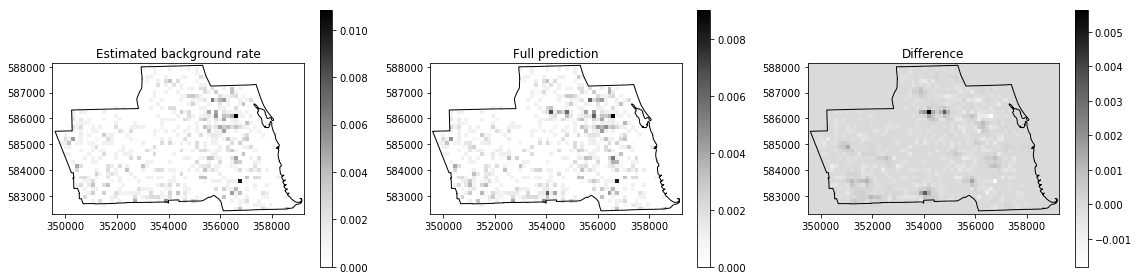

In [10]:
fig, axes = plt.subplots(ncols=3, figsize=(16,4))

for ax in axes:
    ax.add_patch(descartes.PolygonPatch(geo, fc="none"))
    ax.set_aspect(1)
    
mappable = axes[0].pcolor(*back.mesh_data(), back.intensity_matrix, cmap="Greys", rasterized=True)
fig.colorbar(mappable, ax=axes[0])
axes[0].set_title("Estimated background rate")

mappable = axes[1].pcolor(*pred.mesh_data(), pred.intensity_matrix, cmap="Greys", rasterized=True)
fig.colorbar(mappable, ax=axes[1])
axes[1].set_title("Full prediction")

mat = pred.intensity_matrix - back.intensity_matrix
mappable = axes[2].pcolor(*pred.mesh_data(), mat, cmap="Greys", rasterized=True)
fig.colorbar(mappable, ax=axes[2])
axes[2].set_title("Difference")

fig.tight_layout()

In [11]:
fp = predictor.to_fast_split_predictor()
start = time.clock()
fp.data = score_points
fpred = fp.predict(datetime.datetime(2016, 10, 1), end_time=datetime.datetime(2016, 10, 2),
                        time_samples=5, space_samples=-5)
time.clock() - start

641.5900000000001

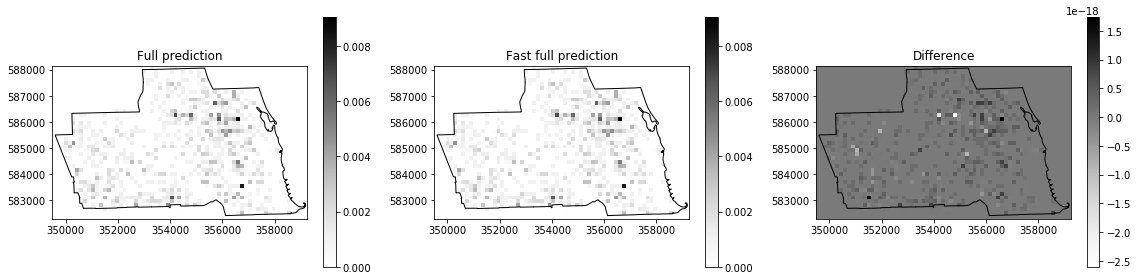

In [12]:
fig, axes = plt.subplots(ncols=3, figsize=(16,4))

for ax in axes:
    ax.add_patch(descartes.PolygonPatch(geo, fc="none"))
    ax.set_aspect(1)
    
mappable = axes[0].pcolor(*pred.mesh_data(), pred.intensity_matrix, cmap="Greys", rasterized=True)
fig.colorbar(mappable, ax=axes[0])
axes[0].set_title("Full prediction")

mappable = axes[1].pcolor(*fpred.mesh_data(), fpred.intensity_matrix, cmap="Greys", rasterized=True)
fig.colorbar(mappable, ax=axes[1])
axes[1].set_title("Fast full prediction")

mat = pred.intensity_matrix - fpred.intensity_matrix
mappable = axes[2].pcolor(*pred.mesh_data(), mat, cmap="Greys", rasterized=True)
fig.colorbar(mappable, ax=axes[2])
axes[2].set_title("Difference")

fig.tight_layout()

In [17]:
fph = predictor.to_fast_split_predictor_histogram(time_bin_size=0.1, space_bin_size=10)
start = time.clock()
fph.data = score_points
fpredh = fph.predict(datetime.datetime(2016, 10, 1), end_time=datetime.datetime(2016, 10, 2),
                        time_samples=5, space_samples=-5)
time.clock() - start

3.640000000001237

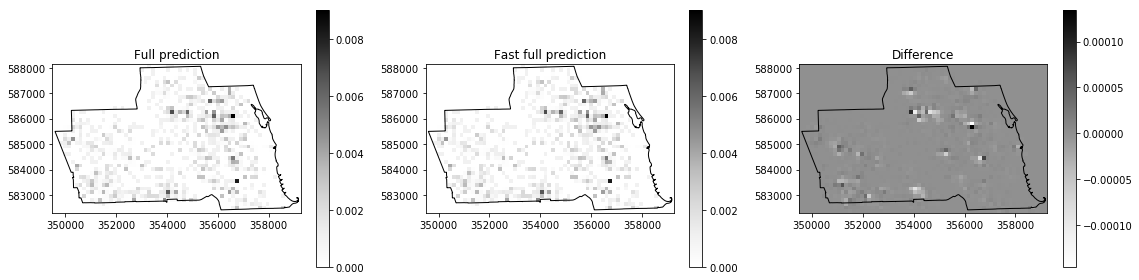

In [18]:
fig, axes = plt.subplots(ncols=3, figsize=(16,4))

for ax in axes:
    ax.add_patch(descartes.PolygonPatch(geo, fc="none"))
    ax.set_aspect(1)
    
mappable = axes[0].pcolor(*pred.mesh_data(), pred.intensity_matrix, cmap="Greys", rasterized=True)
fig.colorbar(mappable, ax=axes[0])
axes[0].set_title("Full prediction")

mappable = axes[1].pcolor(*fpredh.mesh_data(), fpredh.intensity_matrix, cmap="Greys", rasterized=True)
fig.colorbar(mappable, ax=axes[1])
axes[1].set_title("Fast full prediction")

mat = pred.intensity_matrix - fpredh.intensity_matrix
mappable = axes[2].pcolor(*pred.mesh_data(), mat, cmap="Greys", rasterized=True)
fig.colorbar(mappable, ax=axes[2])
axes[2].set_title("Difference")

fig.tight_layout()

# Train with `sepp_fixed.GridTrainer`

In [9]:
tk = sepp.sepp_fixed.ExpTimeKernel(0.2)
sk = sepp.sepp_fixed.GaussianSpaceKernel(50)
trainer = sepp.sepp_fixed.GridTrainer(grid, tk, sk)
trainer.data = points
model = trainer.train(datetime.datetime(2017,1,1), iterations=50)
model

GridModel(mu size=(39, 65), T=365.9583333333333, theta=0.05446048512212478, f=ExpTimeKernel(omega=0.2), g=GaussianSpaceKernel(sigma=50))

In [10]:
predictor = trainer.to_predictor(model)
predictor.data = score_points
start = time.clock()
pred = predictor.predict(datetime.datetime(2016, 10, 1), end_time=datetime.datetime(2016, 10, 2),
                        time_samples=5, space_samples=-5)
print(time.clock() - start)
back = predictor.background_predict(datetime.datetime(2016, 10, 1), space_samples=-5)

50.88080128


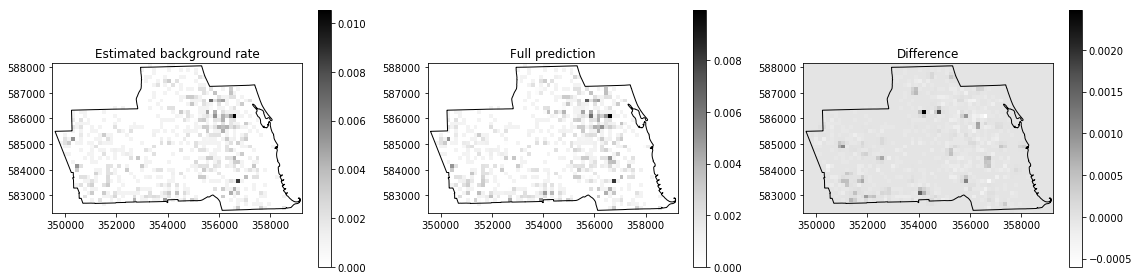

In [11]:
fig, axes = plt.subplots(ncols=3, figsize=(16,4))

for ax in axes:
    ax.add_patch(descartes.PolygonPatch(geo, fc="none"))
    ax.set_aspect(1)
    
mappable = axes[0].pcolor(*back.mesh_data(), back.intensity_matrix, cmap="Greys", rasterized=True)
fig.colorbar(mappable, ax=axes[0])
axes[0].set_title("Estimated background rate")

mappable = axes[1].pcolor(*pred.mesh_data(), pred.intensity_matrix, cmap="Greys", rasterized=True)
fig.colorbar(mappable, ax=axes[1])
axes[1].set_title("Full prediction")

mat = pred.intensity_matrix - back.intensity_matrix
mappable = axes[2].pcolor(*pred.mesh_data(), mat, cmap="Greys", rasterized=True)
fig.colorbar(mappable, ax=axes[2])
axes[2].set_title("Difference")

fig.tight_layout()

In [12]:
fp = predictor.to_fast_split_predictor()
start = time.clock()
fp.data = score_points
fpred = fp.predict(datetime.datetime(2016, 10, 1), end_time=datetime.datetime(2016, 10, 2),
                        time_samples=5, space_samples=-5)
time.clock() - start

5.267478186666665

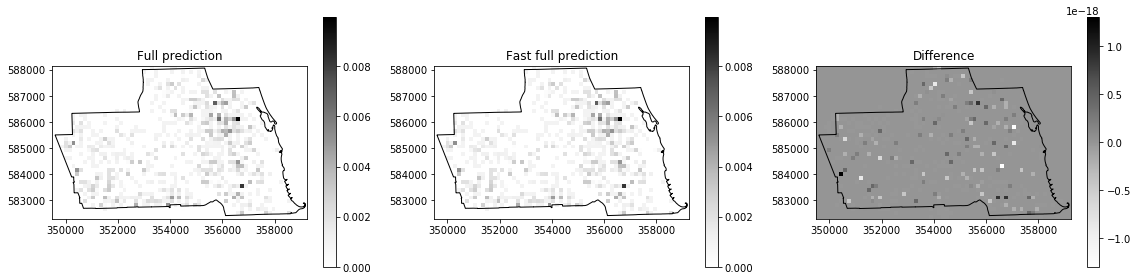

In [13]:
fig, axes = plt.subplots(ncols=3, figsize=(16,4))

for ax in axes:
    ax.add_patch(descartes.PolygonPatch(geo, fc="none"))
    ax.set_aspect(1)
    
mappable = axes[0].pcolor(*pred.mesh_data(), pred.intensity_matrix, cmap="Greys", rasterized=True)
fig.colorbar(mappable, ax=axes[0])
axes[0].set_title("Full prediction")

mappable = axes[1].pcolor(*fpred.mesh_data(), fpred.intensity_matrix, cmap="Greys", rasterized=True)
fig.colorbar(mappable, ax=axes[1])
axes[1].set_title("Fast full prediction")

mat = pred.intensity_matrix - fpred.intensity_matrix
mappable = axes[2].pcolor(*pred.mesh_data(), mat, cmap="Greys", rasterized=True)
fig.colorbar(mappable, ax=axes[2])
axes[2].set_title("Difference")

fig.tight_layout()

In [14]:
tk = sepp.sepp_fixed.ExpTimeKernel(0.2)
sk = sepp.sepp_fixed.GaussianSpaceKernel(50)
trainer = sepp.sepp_fixed.GridTrainerFixedTheta(grid, tk, sk, 0.1)
trainer.data = points
model = trainer.train(datetime.datetime(2017,1,1), iterations=50)
model

GridModel(mu size=(39, 65), T=365.9583333333333, theta=0.1, f=ExpTimeKernel(omega=0.2), g=GaussianSpaceKernel(sigma=50))

In [15]:
predictor = trainer.to_predictor(model)
predictor.data = score_points
start = time.clock()
pred = predictor.predict(datetime.datetime(2016, 10, 1), end_time=datetime.datetime(2016, 10, 2),
                        time_samples=5, space_samples=-5)
print(time.clock() - start)
back = predictor.background_predict(datetime.datetime(2016, 10, 1), space_samples=-5)

48.63266503111109


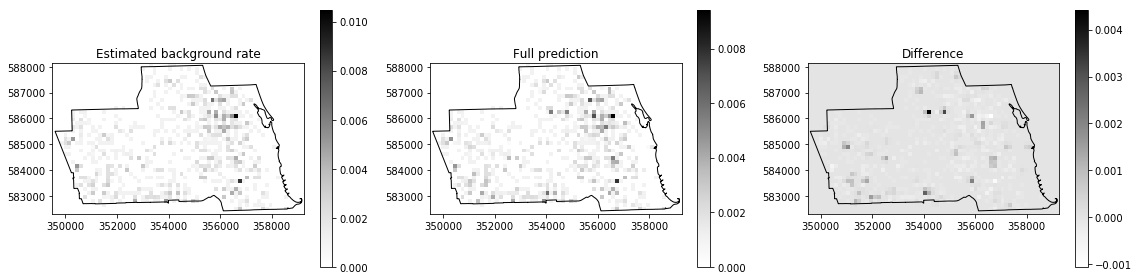

In [16]:
fig, axes = plt.subplots(ncols=3, figsize=(16,4))

for ax in axes:
    ax.add_patch(descartes.PolygonPatch(geo, fc="none"))
    ax.set_aspect(1)
    
mappable = axes[0].pcolor(*back.mesh_data(), back.intensity_matrix, cmap="Greys", rasterized=True)
fig.colorbar(mappable, ax=axes[0])
axes[0].set_title("Estimated background rate")

mappable = axes[1].pcolor(*pred.mesh_data(), pred.intensity_matrix, cmap="Greys", rasterized=True)
fig.colorbar(mappable, ax=axes[1])
axes[1].set_title("Full prediction")

mat = pred.intensity_matrix - back.intensity_matrix
mappable = axes[2].pcolor(*pred.mesh_data(), mat, cmap="Greys", rasterized=True)
fig.colorbar(mappable, ax=axes[2])
axes[2].set_title("Difference")

fig.tight_layout()

# Train with `sepp_fixed.KDETrainer`

In [19]:
tk = sepp.sepp_fixed.ExpTimeKernel(0.2)
sk = sepp.sepp_fixed.GaussianSpaceKernel(50)
bkp = sepp.sepp_full.FixedBandwidthKernelProvider(100)
trainer = sepp.sepp_fixed.KDETrainer(tk, sk, bkp)
trainer.data = points
model = trainer.train(datetime.datetime(2017,1,1), iterations=30)
model

KDEModel(T=365.9583333333333, mu=2.329907493550005, background=<open_cp.kernels.GaussianBase object at 0x000002DC7CEFA208>, theta=0.11459079630279982, f=ExpTimeKernel(omega=0.2), g=GaussianSpaceKernel(sigma=50)

In [21]:
predictor = open_cp.sepp_base.Predictor(grid, model)
predictor.data = score_points
start = time.clock()
pred = predictor.predict(datetime.datetime(2016, 10, 1), end_time=datetime.datetime(2016, 10, 2),
                        time_samples=5, space_samples=-5)
print(time.clock() - start)
back = predictor.background_predict(datetime.datetime(2016, 10, 1), space_samples=-5)

76.92110620444447


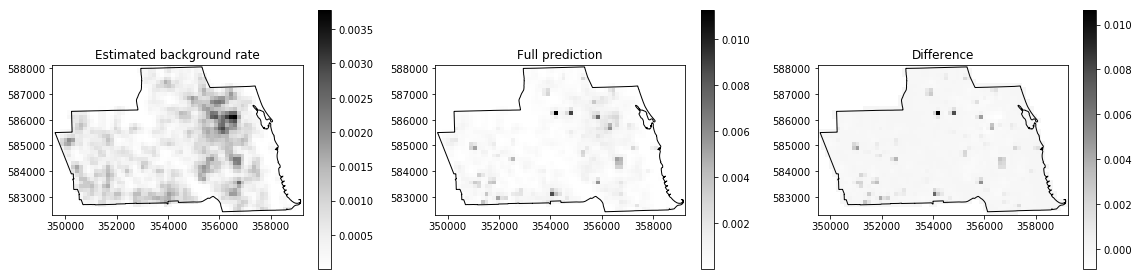

In [22]:
fig, axes = plt.subplots(ncols=3, figsize=(16,4))

for ax in axes:
    ax.add_patch(descartes.PolygonPatch(geo, fc="none"))
    ax.set_aspect(1)
    
mappable = axes[0].pcolor(*back.mesh_data(), back.intensity_matrix, cmap="Greys", rasterized=True)
fig.colorbar(mappable, ax=axes[0])
axes[0].set_title("Estimated background rate")

mappable = axes[1].pcolor(*pred.mesh_data(), pred.intensity_matrix, cmap="Greys", rasterized=True)
fig.colorbar(mappable, ax=axes[1])
axes[1].set_title("Full prediction")

mat = pred.intensity_matrix - back.intensity_matrix
mappable = axes[2].pcolor(*pred.mesh_data(), mat, cmap="Greys", rasterized=True)
fig.colorbar(mappable, ax=axes[2])
axes[2].set_title("Difference")

fig.tight_layout()

In [23]:
fp = predictor.to_fast_split_predictor()
start = time.clock()
fp.data = score_points
fpred = fp.predict(datetime.datetime(2016, 10, 1), end_time=datetime.datetime(2016, 10, 2),
                        time_samples=5, space_samples=-5)
time.clock() - start

13.840189724444372

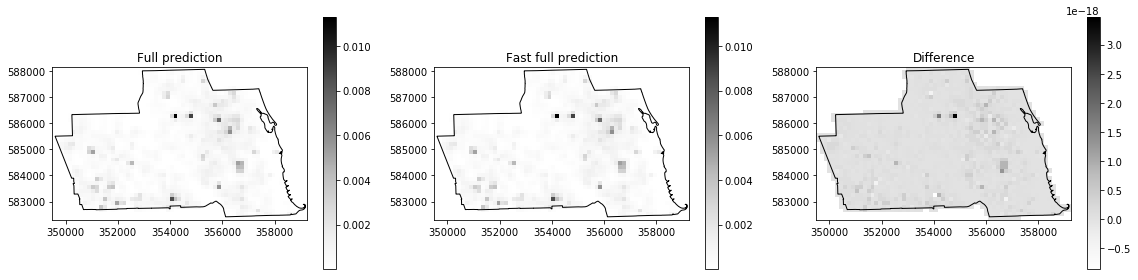

In [24]:
fig, axes = plt.subplots(ncols=3, figsize=(16,4))

for ax in axes:
    ax.add_patch(descartes.PolygonPatch(geo, fc="none"))
    ax.set_aspect(1)
    
mappable = axes[0].pcolor(*pred.mesh_data(), pred.intensity_matrix, cmap="Greys", rasterized=True)
fig.colorbar(mappable, ax=axes[0])
axes[0].set_title("Full prediction")

mappable = axes[1].pcolor(*fpred.mesh_data(), fpred.intensity_matrix, cmap="Greys", rasterized=True)
fig.colorbar(mappable, ax=axes[1])
axes[1].set_title("Fast full prediction")

mat = pred.intensity_matrix - fpred.intensity_matrix
mappable = axes[2].pcolor(*pred.mesh_data(), mat, cmap="Greys", rasterized=True)
fig.colorbar(mappable, ax=axes[2])
axes[2].set_title("Difference")

fig.tight_layout()

# Use `sepp_full`

In [7]:
tk_time_prov = sepp.sepp_full.FixedBandwidthKernelProvider(1)
tk_space_prov = sepp.sepp_full.FixedBandwidthKernelProvider(20, cutoff=750)
back_ker_prov = sepp.sepp_full.FixedBandwidthKernelProvider(100)
opt_fac = sepp.sepp_full.Optimiser1Factory(back_ker_prov, tk_time_prov, tk_space_prov)
trainer = sepp.sepp_full.Trainer1(opt_fac)
trainer.data = points
model = trainer.train(datetime.datetime(2018,1,1), iterations=20)
model

Model1(T=730.9583333333334, mu=0.4695510024698707, background=<open_cp.kernels.GaussianBase object at 0x0000028AF0A781D0>, theta=0.6435906353267158, trigger=<open_cp.kernels.Reflect1D object at 0x0000028AF4049D68>,<function _wrap_with_cutoff.<locals>.kernel at 0x0000028AF3FA4F28>

In [9]:
predictor = open_cp.sepp_base.Predictor(grid, model)
predictor.data = score_points

In [8]:
start = time.clock()
pred = predictor.predict(datetime.datetime(2016, 10, 1), end_time=datetime.datetime(2016, 10, 2),
                        time_samples=5, space_samples=-5)
print(time.clock() - start)
back = predictor.background_predict(datetime.datetime(2016, 10, 1), space_samples=-5)

284088.92308932927


Who knows if this is accurate, as the computer was suspended any number of times while it was running.  Anyway, it took forever...!

In [14]:
fp = predictor.to_fast_split_predictor()
start = time.clock()
fp.data = score_points
fpred = fp.predict(datetime.datetime(2016, 10, 1), end_time=datetime.datetime(2016, 10, 2),
                        time_samples=5, space_samples=-5)
time.clock() - start

9964.583406530393

In [19]:
fp = predictor.to_fast_split_predictor_histogram(0.1, 10)
start = time.clock()
fp.data = score_points
fpred1 = fp.predict(datetime.datetime(2016, 10, 1), end_time=datetime.datetime(2016, 10, 2),
                        time_samples=5, space_samples=-5)
time.clock() - start

5.351219868796761

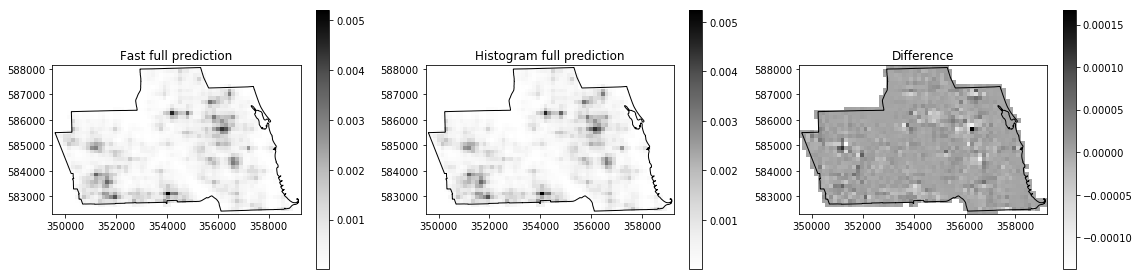

In [20]:
fig, axes = plt.subplots(ncols=3, figsize=(16,4))

for ax in axes:
    ax.add_patch(descartes.PolygonPatch(geo, fc="none"))
    ax.set_aspect(1)
    
mappable = axes[0].pcolor(*fpred.mesh_data(), fpred.intensity_matrix, cmap="Greys", rasterized=True)
fig.colorbar(mappable, ax=axes[0])
axes[0].set_title("Fast full prediction")

mappable = axes[1].pcolor(*fpred1.mesh_data(), fpred1.intensity_matrix, cmap="Greys", rasterized=True)
fig.colorbar(mappable, ax=axes[1])
axes[1].set_title("Histogram full prediction")

mat = fpred.intensity_matrix - fpred1.intensity_matrix
mappable = axes[2].pcolor(*fpred.mesh_data(), mat, cmap="Greys", rasterized=True)
fig.colorbar(mappable, ax=axes[2])
axes[2].set_title("Difference")

fig.tight_layout()